## IMPORTS Y CONFIGURACIÓN


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium
import math
import requests
from tqdm import tqdm
import time
from sklearn.metrics import silhouette_score
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import hdbscan
from geopy.distance import geodesic
from sklearn.neighbors import BallTree
import plotly.graph_objects as go
import plotly.express as px


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ruta_csv = '/content/rome_u_journeys.csv'
df = pd.read_csv(ruta_csv)
df.head()

,idS,tsO,tsD,price,tt,dis,vel,lonO,latO,lonD,latD
0,A0H4,03/02/2021 18:10:03,03/02/2021 18:17:44,2.1525,461,1715.336751,13.395254,12.466222,41.867388,12.470660,41.853908
1,A0H4,13/02/2021 18:21:13,13/02/2021 18:25:33,1.6500,260,1234.472044,17.092690,12.471143,41.923692,12.467502,41.934306
2,A0H4,14/02/2021 13:39:54,14/02/2021 13:48:03,2.2225,489,2221.481536,16.354465,12.467524,41.934342,12.486330,41.928270
3,A0H4,14/02/2021 14:35:03,14/02/2021 14:35:13,1.0250,10,3.712940,1.336658,12.486283,41.928267,12.486276,41.928300
4,A0H4,14/02/2021 14:37:53,14/02/2021 14:57:53,4.0000,1200,4562.843566,13.688531,12.486275,41.928301,12.457922,41.904302


## PREPROCESADO BBDD

### Nuevas Columnas

In [ ]:
# -------------------------------
# Trip_id
# -------------------------------
# Asegurar tipo datetime
df['tsO'] = pd.to_datetime(df['tsO'], format='%d/%m/%Y %H:%M:%S')

# Ordenar por scooter y fecha
df = df.sort_values(by=['idS', 'tsO'])

# Contador por scooter y día
df['viaje_dia'] = df.groupby(['idS', df['tsO'].dt.date]).cumcount() + 1

# Crear id único (formato: idS + YYMMDD + contador)
df['id_viaje'] = (
    df['idS']
    + df['tsO'].dt.strftime('%y%m%d')
    + df['viaje_dia'].astype(str)
)

In [ ]:
# ------------------------------------------------------------
# Función batch para consultar altitudes
# ------------------------------------------------------------
def obtener_altitudes_batch(lista_coordenadas, batch_size=300, reintentos=3):
    """
    Recibe una lista de coordenadas [(lat, lon), (lat, lon), ...]
    Devuelve una lista de altitudes en el mismo orden.
    """
    altitudes = []

    # Recorrer en lotes
    for i in tqdm(range(0, len(lista_coordenadas), batch_size), desc="Obteniendo altitudes"):
        batch = lista_coordenadas[i : i + batch_size]

        # Crear string para API
        loc_str = "|".join([f"{lat},{lon}" for lat, lon in batch])
        url = f"https://api.open-elevation.com/api/v1/lookup?locations={loc_str}"

        # Sistema de reintentos
        for intento in range(reintentos):
            try:
                response = requests.get(url, timeout=10)
                data = response.json()

                if "results" in data:
                    altitudes.extend([res["elevation"] for res in data["results"]])
                else:
                    altitudes.extend([None] * len(batch))

                time.sleep(0.2)  # para no saturar la API
                break

            except Exception:
                print(f"Error en batch {i} intento {intento+1}. Reintentando...")
                time.sleep(1)

        else:
            # Si fallan todos los reintentos
            altitudes.extend([None] * len(batch))

    return altitudes

In [ ]:
# ------------------------------------------------------------
# Función principal diff_altura
# ------------------------------------------------------------
def diff_altura(df):
    """
    Añade únicamente la columna diff_altura al DataFrame usando consultas batch.
    """
    print("Preparando coordenadas...")

    coords_origen = list(zip(df["latO"], df["lonO"]))
    coords_destino = list(zip(df["latD"], df["lonD"]))

    print("Obteniendo altitudes de ORIGEN...")
    altO = obtener_altitudes_batch(coords_origen)

    print("Obteniendo altitudes de DESTINO...")
    altD = obtener_altitudes_batch(coords_destino)

    # Solo añadimos diff_altura, sin guardar altO ni altD
    df["diff_altura"] = [d - o for d, o in zip(altD, altO)]

    print("Columna diff_altura añadida correctamente.")

    return df

df = diff_altura(df)

Preparando coordenadas...
Obteniendo altitudes de ORIGEN...


Obteniendo altitudes: 100%|██████████| 84/84 [01:00<00:00,  1.38it/s]


Obteniendo altitudes de DESTINO...


Obteniendo altitudes: 100%|██████████| 84/84 [01:00<00:00,  1.39it/s]

Columna diff_altura añadida correctamente.


In [ ]:
# ------------------------------------------------------------
# Pendiente media (%)
# ------------------------------------------------------------
df['pendiente'] = (df['diff_altura'] / df['dis']) * 100

### Comprobaciones

In [ ]:
df_test = df.copy()

#### Distancia

In [ ]:
# Función Haversine para distancia en metros
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # radio de la Tierra en metros

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c

# Crear nueva columna con distancia en línea recta
df_test['dist_New'] = haversine(df_test['latO'], df_test['lonO'], df_test['latD'], df_test['lonD'])
df_test[['dis', 'dist_New']].head()

,dis,dist_New
0,1715.336751,1543.309227
1,1234.472044,1218.052152
2,2221.481536,1695.887445
3,3.712940,3.714846
4,4562.843566,3553.162211


In [ ]:
# Crear diferencias absolutas y relativas
df_test['diff'] = df_test['dis'] - df_test['dist_New']
df_test['diff_abs'] = abs(df_test['diff'])
df_test['diff_pct'] = (df_test['diff_abs'] / df_test['dist_New']) * 100

# Mostrar algunas filas
df_test[['dis', 'dist_New', 'diff', 'diff_abs', 'diff_pct']].head(10)


,dis,dist_New,diff,diff_abs,diff_pct
0,1715.336751,1543.309227,172.027524,172.027524,11.146666
1,1234.472044,1218.052152,16.419892,16.419892,1.348045
2,2221.481536,1695.887445,525.594091,525.594091,30.992274
3,3.712940,3.714846,-0.001906,0.001906,0.051312
4,4562.843566,3553.162211,1009.681355,1009.681355,28.416416
5,550.154792,438.599428,111.555364,111.555364,25.434453
6,1067.878564,793.455528,274.423037,274.423037,34.585812
7,998.787405,907.326525,91.460880,91.460880,10.080261
8,1008.075016,843.796936,164.278080,164.278080,19.468912
9,5388.969536,4144.809559,1244.159977,1244.159977,30.017301


In [ ]:
print("Media diferencia (m):", df_test['diff_abs'].mean())
print("Mediana diferencia (m):", df_test['diff_abs'].median())
print("Máxima diferencia (m):", df_test['diff_abs'].max())
print("Porcentaje medio error (%):", df_test['diff_pct'].mean())


Media diferencia (m): 776.0149671517792
Mediana diferencia (m): 383.2066355147722
Máxima diferencia (m): 17869.608537662425
Porcentaje medio error (%): inf


#### Velocidad

In [ ]:
# Crear nueva columna de velocidad calculada a partir de dist_New y tiempo tt
df_test['vel_New'] = (df_test['dist_New'] / df_test['tt']) * 3.6

# Mostrar primeras filas
df_test[['vel', 'vel_New']].head()

,vel,vel_New
0,13.395254,12.051872
1,17.092690,16.865337
2,16.354465,12.485061
3,1.336658,1.337344
4,13.688531,10.659487


In [ ]:
# Crear diferencias
df_test['vel_diff'] = df_test['vel'] - df_test['vel_New']
df_test['vel_diff_abs'] = abs(df_test['vel_diff'])
df_test['vel_diff_pct'] = (df_test['vel_diff_abs'] / df_test['vel_New']) * 100

# Mostrar algunas filas
df_test[['vel', 'vel_New', 'vel_diff', 'vel_diff_abs', 'vel_diff_pct']].head(10)


,vel,vel_New,vel_diff,vel_diff_abs,vel_diff_pct
0,13.395254,12.051872,1.343382,1.343382,11.146666
1,17.092690,16.865337,0.227352,0.227352,1.348045
2,16.354465,12.485061,3.869404,3.869404,30.992274
3,1.336658,1.337344,-0.000686,0.000686,0.051312
4,13.688531,10.659487,3.029044,3.029044,28.416416
5,9.853519,7.855512,1.998007,1.998007,25.434453
6,7.239855,5.379360,1.860495,1.860495,34.585812
7,15.633194,14.201633,1.431562,1.431562,10.080261
8,12.960964,10.848818,2.112147,2.112147,19.468912
9,14.586684,11.219033,3.367651,3.367651,30.017301


In [ ]:
print("Media diferencia vel (km/h):", df_test['vel_diff_abs'].mean())
print("Mediana diferencia vel (km/h):", df_test['vel_diff_abs'].median())
print("Máxima diferencia vel (km/h):", df_test['vel_diff_abs'].max())
print("Porcentaje medio error vel (%):", df_test['vel_diff_pct'].mean())


Media diferencia vel (km/h): 3.5858461061217297
Mediana diferencia vel (km/h): 2.9974896415762604
Máxima diferencia vel (km/h): 20.876956000609777
Porcentaje medio error vel (%): inf


### Borrado de Outliers

In [ ]:
# 1. Velocidades > 25 km/h
out_vel = df[df["vel"] > 25]
print(f"Registros con velocidad > 25 km/h: {len(out_vel)}")

# 2. Viajes con tt > 3 horas  (3h = 10800 s)
out_tt_muy_largo = df[df["tt"] > 10800]
print(f"Registros con tt > 3 horas: {len(out_tt_muy_largo)}")

# 3. Viajes con tt < 30 s
out_tt_muy_corto = df[df["tt"] < 30]
print(f"Registros con tt < 30 segundos: {len(out_tt_muy_corto)}")

# 4. Viajes fuera de Roma
out_coords = df[
    (df["latO"] < 41.78) | (df["latO"] > 41.99) |
    (df["latD"] < 41.78) | (df["latD"] > 41.99) |
    (df["lonO"] < 12.38) | (df["lonO"] > 12.63) |
    (df["lonD"] < 12.38) | (df["lonD"] > 12.63)
]

print(f"Trayectos fuera de Roma: {len(out_coords)}")

# 5. Viajes con distancia <5m y tiempo >90s
out_dist_cero = df[(df["dis"] < 5) & (df["tt"] > 90)]
print(f"Distancia casi 0 pero tiempo alto: {len(out_dist_cero)}")

# 6. Imprimir TOTAL
total_outliers = len(out_vel) + len(out_tt_muy_largo) + len(out_tt_muy_corto) + len(out_coords) + len(out_dist_cero)
print(f"\nTotal de registros marcados como outliers: {total_outliers}")


Registros con velocidad > 25 km/h: 2
Registros con tt > 3 horas: 79
Registros con tt < 30 segundos: 391
Trayectos fuera de Roma: 0
Distancia casi 0 pero tiempo alto: 82

Total de registros marcados como outliers: 554


In [ ]:
df.head()

,idS,tsO,tsD,price,tt,dis,vel,lonO,latO,lonD,latD,viaje_dia,id_viaje,diff_altura,pendiente
0,A0H4,2021-02-03 18:10:03,03/02/2021 18:17:44,2.1525,461,1715.336751,13.395254,12.466222,41.867388,12.470660,41.853908,1,A0H42102031,-9.0,-0.524678
1,A0H4,2021-02-13 18:21:13,13/02/2021 18:25:33,1.6500,260,1234.472044,17.092690,12.471143,41.923692,12.467502,41.934306,1,A0H42102131,-3.0,-0.243019
2,A0H4,2021-02-14 13:39:54,14/02/2021 13:48:03,2.2225,489,2221.481536,16.354465,12.467524,41.934342,12.486330,41.928270,1,A0H42102141,33.0,1.485495
3,A0H4,2021-02-14 14:35:03,14/02/2021 14:35:13,1.0250,10,3.712940,1.336658,12.486283,41.928267,12.486276,41.928300,2,A0H42102142,0.0,0.000000
4,A0H4,2021-02-14 14:37:53,14/02/2021 14:57:53,4.0000,1200,4562.843566,13.688531,12.486275,41.928301,12.457922,41.904302,3,A0H42102143,-32.0,-0.701317


In [ ]:
# Creamos una copia limpia
df_clean = df.copy()

# 1. Velocidad válida (<= 25 km/h)
df_clean = df_clean[df_clean["vel"] <= 25]

# 2. Tiempo válido (>= 30s y <= 3h)
df_clean = df_clean[(df_clean["tt"] >= 30) & (df_clean["tt"] <= 10800)]

# 3. Coordenadas dentro del bounding box de Roma
df_clean = df_clean[
    (df_clean["latO"] >= 41.78) & (df_clean["latO"] <= 41.99) &
    (df_clean["latD"] >= 41.78) & (df_clean["latD"] <= 41.99) &
    (df_clean["lonO"] >= 12.38) & (df_clean["lonO"] <= 12.63) &
    (df_clean["lonD"] >= 12.38) & (df_clean["lonD"] <= 12.63)
]

# 4. Distancia mínima lógica (>= 5 m) si el viaje dura más de 90s
df_clean = df_clean[~((df_clean["dis"] < 5) & (df_clean["tt"] > 90))]

# Mostrar resultados
print("Datos eliminados correctamente.")
print(f"Filas originales: {len(df)}")
print(f"Filas después de limpiar: {len(df_clean)}")
print(f"Filas eliminadas: {len(df) - len(df_clean)}")


Datos eliminados correctamente.
Filas originales: 25186
Filas después de limpiar: 24632
Filas eliminadas: 554


## EDA

In [ ]:
df_eda = df_clean.copy()
# Configurar estilo de gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# ==================================================
# 1. PREPARAR DATOS TEMPORALES
# ==================================================

print("Preparando datos temporales...")

# Convertir tsD a datetime (con formato día/mes/año)
df_eda['tsD'] = pd.to_datetime(df_eda['tsD'], dayfirst=True)

# Extraer información temporal de tsO (que ya está en datetime)
df_eda['fecha'] = df_eda['tsO'].dt.date
df_eda['hora'] = df_eda['tsO'].dt.hour
df_eda['dia_semana'] = df_eda['tsO'].dt.dayofweek  # 0=Lunes, 6=Domingo
df_eda['nombre_dia'] = df_eda['tsO'].dt.day_name()

# Mapeo de días en español
dias_español = {
    'Monday': 'Lunes',
    'Tuesday': 'Martes',
    'Wednesday': 'Miércoles',
    'Thursday': 'Jueves',
    'Friday': 'Viernes',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
}
df_eda['nombre_dia_es'] = df_eda['nombre_dia'].map(dias_español)

print(f"✅ Datos preparados")
print(f"📅 Rango de fechas: {df_eda['fecha'].min()} a {df_eda['fecha'].max()}")
print(f"📊 Total de viajes: {len(df_eda)}")


Preparando datos temporales...
✅ Datos preparados
📅 Rango de fechas: 2021-02-01 a 2021-02-28
📊 Total de viajes: 24632


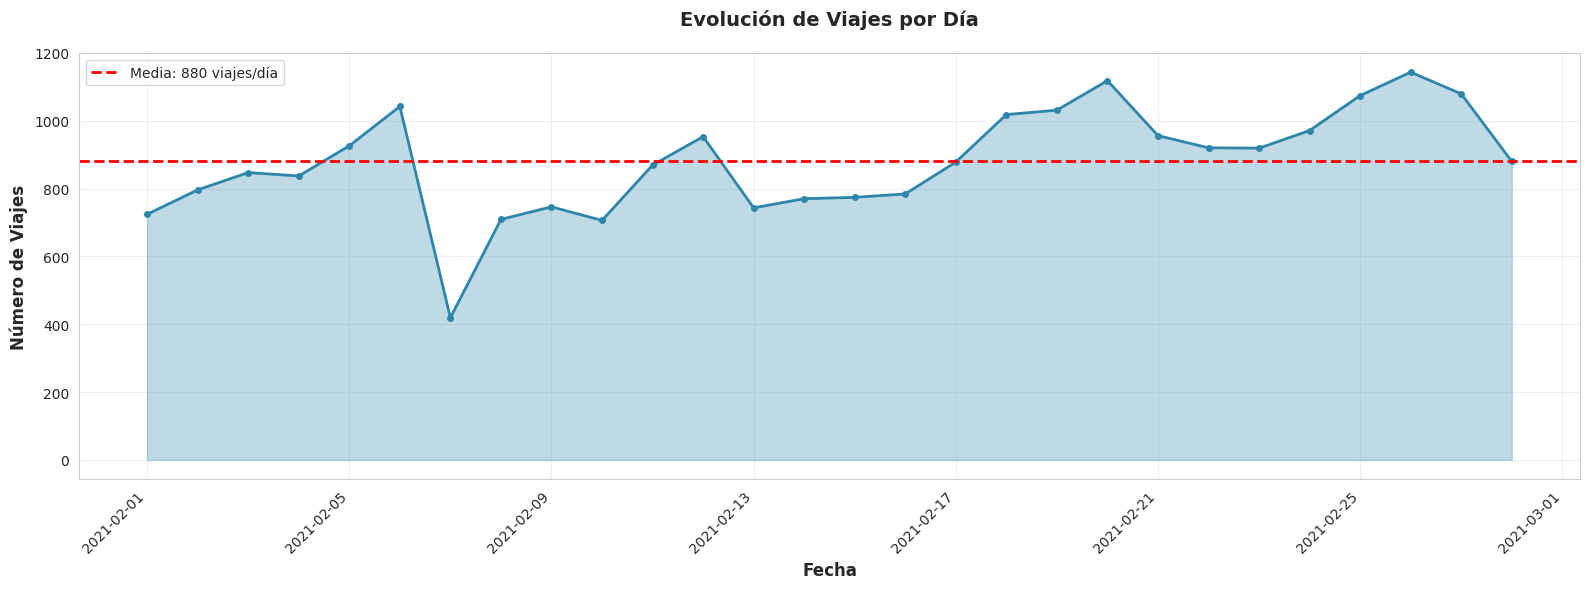


ESTADÍSTICAS DE VIAJES POR DÍA
📊 Media: 879.7 viajes/día
📈 Máximo: 1143 viajes (día: 2021-02-26)
📉 Mínimo: 419 viajes (día: 2021-02-07)
📊 Mediana: 879.0 viajes/día
📊 Desviación estándar: 157.7 viajes/día


In [ ]:
# ==================================================
# 2. GRÁFICA: VIAJES POR DÍA
# ==================================================

# Contar viajes por día
viajes_por_dia = df_eda.groupby('fecha').size().reset_index(name='num_viajes')
viajes_por_dia['fecha'] = pd.to_datetime(viajes_por_dia['fecha'])

# Crear gráfica
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(viajes_por_dia['fecha'], viajes_por_dia['num_viajes'],
        marker='o', linewidth=2, markersize=4, color='#2E86AB')
ax.fill_between(viajes_por_dia['fecha'], viajes_por_dia['num_viajes'],
                alpha=0.3, color='#2E86AB')

# Añadir línea de media
media_viajes = viajes_por_dia['num_viajes'].mean()
ax.axhline(y=media_viajes, color='red', linestyle='--',
          linewidth=2, label=f'Media: {media_viajes:.0f} viajes/día')

ax.set_xlabel('Fecha', fontsize=12, fontweight='bold')
ax.set_ylabel('Número de Viajes', fontsize=12, fontweight='bold')
ax.set_title('Evolución de Viajes por Día', fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Rotar etiquetas del eje x
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Estadísticas
print(f"\n{'='*50}")
print(f"ESTADÍSTICAS DE VIAJES POR DÍA")
print(f"{'='*50}")
print(f"📊 Media: {viajes_por_dia['num_viajes'].mean():.1f} viajes/día")
print(f"📈 Máximo: {viajes_por_dia['num_viajes'].max()} viajes (día: {viajes_por_dia.loc[viajes_por_dia['num_viajes'].idxmax(), 'fecha'].strftime('%Y-%m-%d')})")
print(f"📉 Mínimo: {viajes_por_dia['num_viajes'].min()} viajes (día: {viajes_por_dia.loc[viajes_por_dia['num_viajes'].idxmin(), 'fecha'].strftime('%Y-%m-%d')})")
print(f"📊 Mediana: {viajes_por_dia['num_viajes'].median():.1f} viajes/día")
print(f"📊 Desviación estándar: {viajes_por_dia['num_viajes'].std():.1f} viajes/día")



VIAJES PROMEDIO POR DÍA DE LA SEMANA
Lunes       :  781.8 viajes/día
Martes      :  811.2 viajes/día
Miércoles   :  850.5 viajes/día
Jueves      :  949.5 viajes/día
Viernes     : 1013.2 viajes/día
Sábado      :  995.5 viajes/día
Domingo     :  756.2 viajes/día


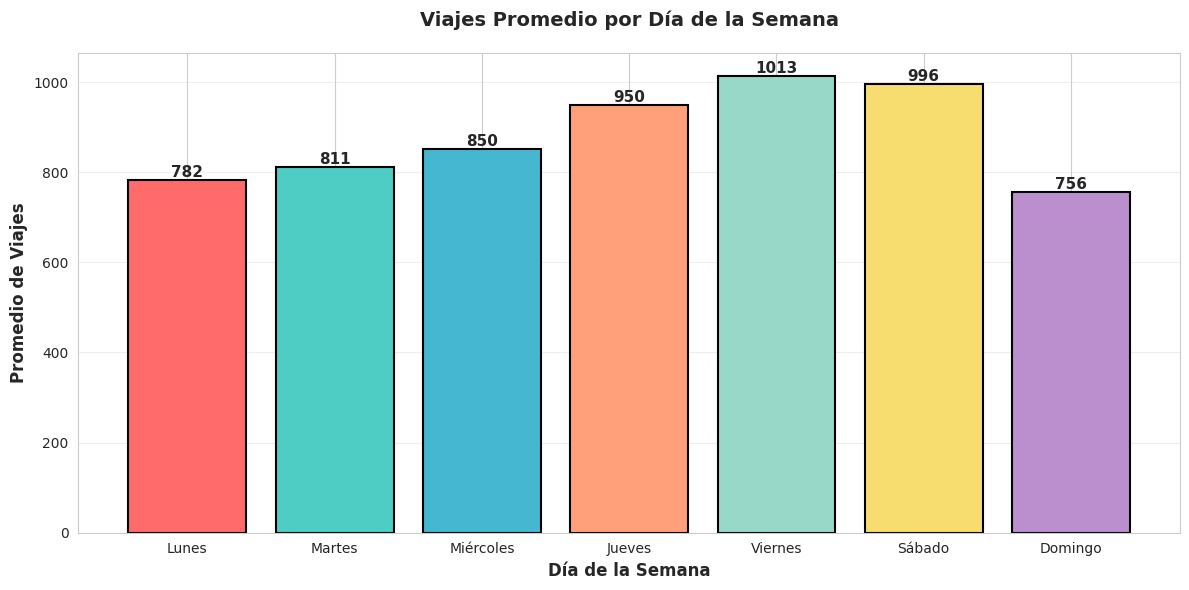

In [ ]:
# ==================================================
# 3. ANÁLISIS POR DÍA DE LA SEMANA
# ==================================================

# Calcular viajes promedio por día de la semana
viajes_por_dia_semana = df_eda.groupby(['dia_semana', 'nombre_dia_es']).size().reset_index(name='total_viajes')
viajes_por_dia_semana = viajes_por_dia_semana.sort_values('dia_semana')

# Calcular promedio por día de la semana
dias_unicos = df_eda.groupby('dia_semana')['fecha'].nunique()
viajes_por_dia_semana['promedio_viajes'] = viajes_por_dia_semana.apply(
    lambda row: row['total_viajes'] / dias_unicos[row['dia_semana']], axis=1
)

print(f"\n{'='*50}")
print(f"VIAJES PROMEDIO POR DÍA DE LA SEMANA")
print(f"{'='*50}")
for _, row in viajes_por_dia_semana.iterrows():
    print(f"{row['nombre_dia_es']:12s}: {row['promedio_viajes']:6.1f} viajes/día")

# Gráfica de barras
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F', '#BB8FCE']
bars = ax.bar(viajes_por_dia_semana['nombre_dia_es'],
              viajes_por_dia_semana['promedio_viajes'],
              color=colors, edgecolor='black', linewidth=1.5)

# Añadir valores en las barras
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.0f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xlabel('Día de la Semana', fontsize=12, fontweight='bold')
ax.set_ylabel('Promedio de Viajes', fontsize=12, fontweight='bold')
ax.set_title('Viajes Promedio por Día de la Semana', fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

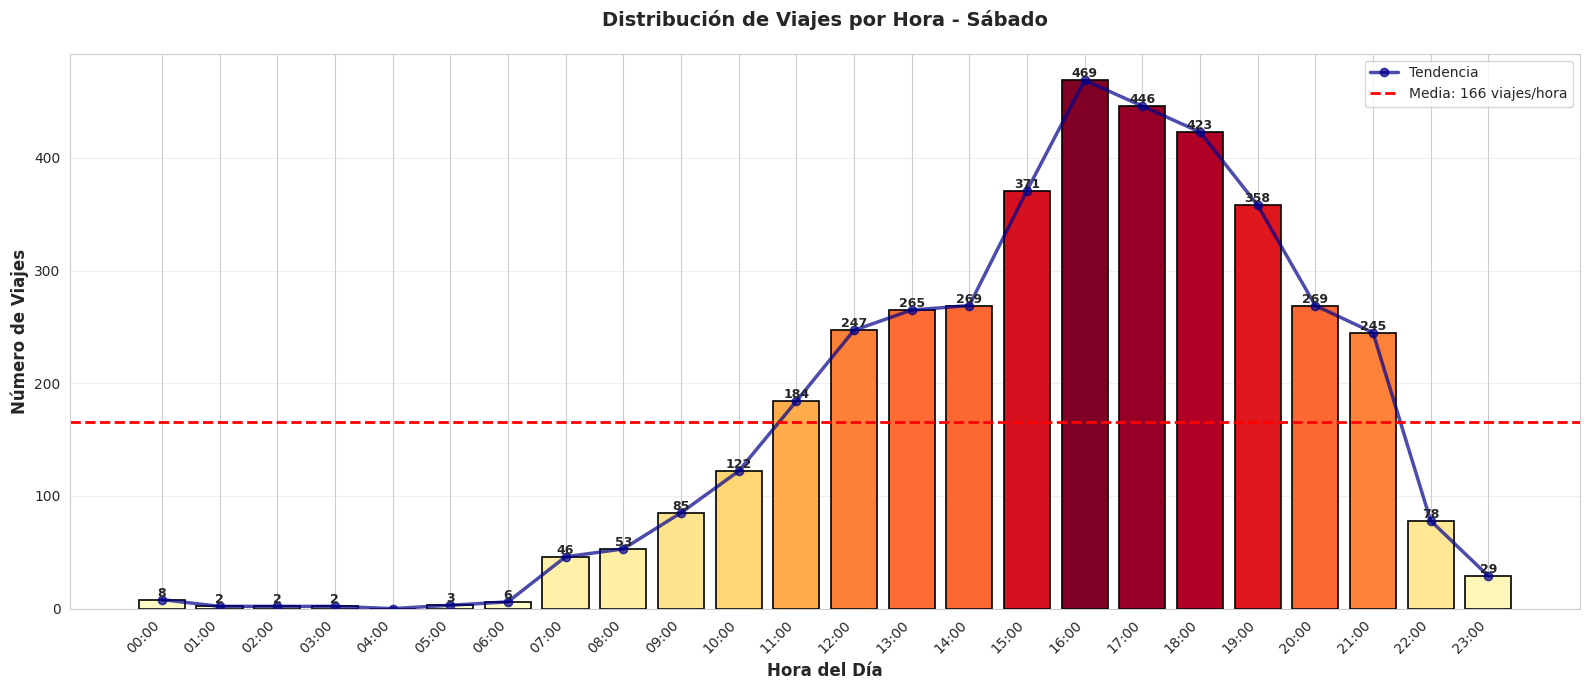


ESTADÍSTICAS - SÁBADO
📊 Total de viajes: 3982
📅 Número de viajes el Sábado en el dataset: 4
📈 Hora pico: 16:00 (469 viajes)
📉 Hora valle: 04:00 (0 viajes)
📊 Media: 165.9 viajes/hora

🕐 FRANJAS HORARIAS:
   Madrugada (00-06): 17 viajes
   Mañana (06-12):    496 viajes
   Tarde (12-18):     2067 viajes
   Noche (18-24):     1402 viajes


,hora,num_viajes
0,0,8.0
1,1,2.0
2,2,2.0
3,3,2.0
4,4,0.0
5,5,3.0
6,6,6.0
7,7,46.0
8,8,53.0
9,9,85.0


In [ ]:
# ==================================================
# 4. FUNCIÓN INTERACTIVA: VIAJES POR HORA SEGÚN DÍA
# ==================================================

def analizar_dia_semana(dia_semana):
    """
    Analiza y plotea los viajes por hora para un día específico de la semana

    Parámetros:
    dia_semana: str - 'L', 'M', 'X', 'J', 'V', 'S', 'D'
    """

    # Mapeo de letras a días
    mapeo_dias = {
        'L': (0, 'Lunes'),
        'M': (1, 'Martes'),
        'X': (2, 'Miércoles'),
        'J': (3, 'Jueves'),
        'V': (4, 'Viernes'),
        'S': (5, 'Sábado'),
        'D': (6, 'Domingo')
    }

    if dia_semana.upper() not in mapeo_dias:
        print("❌ Día no válido. Usa: L, M, X, J, V, S, D")
        return

    dia_num, dia_nombre = mapeo_dias[dia_semana.upper()]

    # Filtrar datos del día específico
    datos_dia = df_eda[df_eda['dia_semana'] == dia_num]

    if len(datos_dia) == 0:
        print(f"❌ No hay datos para {dia_nombre}")
        return

    # Contar viajes por hora
    viajes_por_hora = datos_dia.groupby('hora').size().reset_index(name='num_viajes')

    # Asegurar que tenemos todas las horas (0-23)
    horas_completas = pd.DataFrame({'hora': range(24)})
    viajes_por_hora = horas_completas.merge(viajes_por_hora, on='hora', how='left').fillna(0)

    # Crear gráfica
    fig, ax = plt.subplots(figsize=(16, 7))

    # Colores según intensidad
    colors = plt.cm.YlOrRd(viajes_por_hora['num_viajes'] / viajes_por_hora['num_viajes'].max())

    bars = ax.bar(viajes_por_hora['hora'], viajes_por_hora['num_viajes'],
                  color=colors, edgecolor='black', linewidth=1.2)

    # Añadir valores en las barras
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Línea de tendencia
    ax.plot(viajes_por_hora['hora'], viajes_por_hora['num_viajes'],
            color='darkblue', linewidth=2.5, marker='o', markersize=6,
            linestyle='-', alpha=0.7, label='Tendencia')

    # Línea de media
    media_hora = viajes_por_hora['num_viajes'].mean()
    ax.axhline(y=media_hora, color='red', linestyle='--',
              linewidth=2, label=f'Media: {media_hora:.0f} viajes/hora')

    # Configuración de ejes
    ax.set_xlabel('Hora del Día', fontsize=12, fontweight='bold')
    ax.set_ylabel('Número de Viajes', fontsize=12, fontweight='bold')
    ax.set_title(f'Distribución de Viajes por Hora - {dia_nombre}',
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(range(24))
    ax.set_xticklabels([f'{h:02d}:00' for h in range(24)], rotation=45, ha='right')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    # Estadísticas
    print(f"\n{'='*50}")
    print(f"ESTADÍSTICAS - {dia_nombre.upper()}")
    print(f"{'='*50}")
    print(f"📊 Total de viajes: {len(datos_dia)}")
    print(f"📅 Número de viajes el {dia_nombre} en el dataset: {datos_dia['fecha'].nunique()}")
    print(f"📈 Hora pico: {int(viajes_por_hora.loc[viajes_por_hora['num_viajes'].idxmax(), 'hora']):02d}:00 ({int(viajes_por_hora['num_viajes'].max())} viajes)")
    print(f"📉 Hora valle: {int(viajes_por_hora.loc[viajes_por_hora['num_viajes'].idxmin(), 'hora']):02d}:00 ({int(viajes_por_hora['num_viajes'].min())} viajes)")
    print(f"📊 Media: {media_hora:.1f} viajes/hora")

    # Identificar franjas horarias
    print(f"\n🕐 FRANJAS HORARIAS:")
    print(f"   Madrugada (00-06): {int(viajes_por_hora[viajes_por_hora['hora'] < 6]['num_viajes'].sum())} viajes")
    print(f"   Mañana (06-12):    {int(viajes_por_hora[(viajes_por_hora['hora'] >= 6) & (viajes_por_hora['hora'] < 12)]['num_viajes'].sum())} viajes")
    print(f"   Tarde (12-18):     {int(viajes_por_hora[(viajes_por_hora['hora'] >= 12) & (viajes_por_hora['hora'] < 18)]['num_viajes'].sum())} viajes")
    print(f"   Noche (18-24):     {int(viajes_por_hora[viajes_por_hora['hora'] >= 18]['num_viajes'].sum())} viajes")

    return viajes_por_hora

analizar_dia_semana('S')

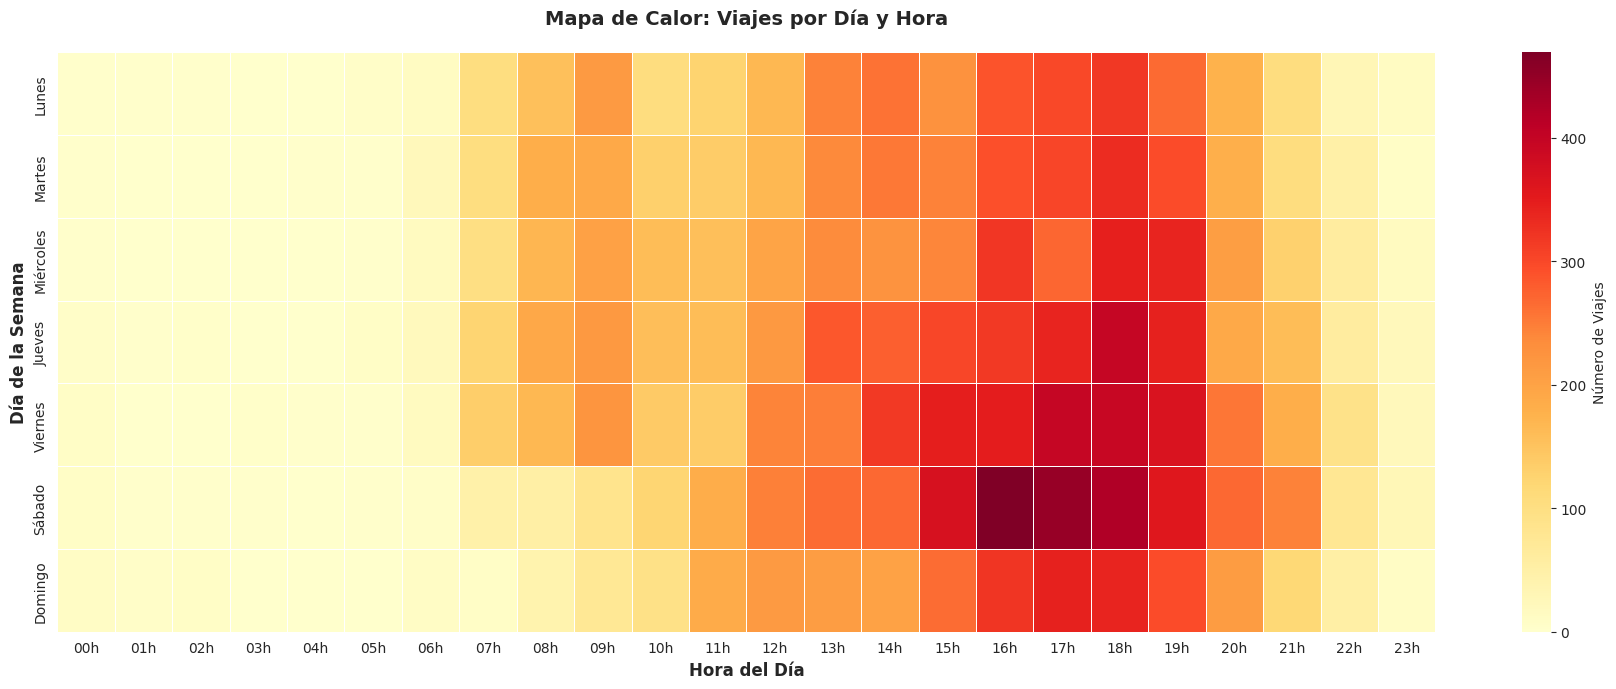

In [ ]:
# ==================================================
# 5. HEATMAP: TODOS LOS DÍAS Y HORAS
# ==================================================

# Crear matriz de viajes por día de semana y hora
heatmap_data = df_eda.groupby(['dia_semana', 'hora']).size().reset_index(name='num_viajes')
heatmap_pivot = heatmap_data.pivot(index='dia_semana', columns='hora', values='num_viajes').fillna(0)

# Renombrar índices con nombres de días en español
dias_orden = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
heatmap_pivot.index = dias_orden

# Crear heatmap
fig, ax = plt.subplots(figsize=(18, 7))
sns.heatmap(heatmap_pivot, annot=False, fmt='.0f', cmap='YlOrRd',
            cbar_kws={'label': 'Número de Viajes'}, linewidths=0.5, ax=ax)

ax.set_xlabel('Hora del Día', fontsize=12, fontweight='bold')
ax.set_ylabel('Día de la Semana', fontsize=12, fontweight='bold')
ax.set_title('Mapa de Calor: Viajes por Día y Hora', fontsize=14, fontweight='bold', pad=20)
ax.set_xticklabels([f'{h:02d}h' for h in range(24)], rotation=0)
plt.tight_layout()
plt.show()

## Modelo HDBSCAN

In [ ]:
min_dist_m = 400
min_cluster_size=60
min_samples=15

# Combina origen y destino en un solo array de coordenadas
coords_origen = df_clean[['latO', 'lonO']].dropna()
coords_destino = df_clean[['latD', 'lonD']].dropna()
coords = pd.concat([coords_origen, coords_destino]).drop_duplicates().reset_index(drop=True)
coords_array = coords[['latO', 'lonO']].values if 'latO' in coords else coords.values

coords_radians = np.radians(coords_array)

# Parámetros iniciales recomendados
clusterer = hdbscan.HDBSCAN(
    min_cluster_size,     # Tamaño de los clusters
    min_samples,
    metric='haversine'
)
labels = clusterer.fit_predict(coords_radians)
coords['cluster'] = labels
clusters_validos = coords[coords['cluster'] != -1]

# Combina origen y destino como puntos independientes
centroides = []
for cluster_id in clusters_validos['cluster'].unique():
    cluster = clusters_validos[clusters_validos['cluster'] == cluster_id]

    # Toma todos los puntos de origen y destino como filas separadas
    puntos_origen = cluster[['latO', 'lonO']].dropna().values
    puntos_destino = cluster[['latD', 'lonD']].dropna().values
    puntos = np.vstack([puntos_origen, puntos_destino])

    # Calcula el centroide
    centroide = np.mean(puntos, axis=0)
    centroides.append(centroide)

centroides = np.array(centroides)

def filtra_centroides(centroides, min_dist):
    seleccionados = []
    for centro in centroides:
        if all(geodesic(tuple(centro), tuple(sel)).m >= min_dist for sel in seleccionados):
            seleccionados.append(tuple(centro))
    return np.array(seleccionados)

estaciones_finales = filtra_centroides(centroides, min_dist_m)
# Filtra NaNs de coordenadas de origen
origen_validos = coords[['latO', 'lonO']].dropna()


In [ ]:
# ================================================================
# ASIGNACIÓN DE ESTACIONES DE ORIGEN Y DESTINO
# ================================================================

# Convertimos estaciones a array (lat, lon)
est_array = np.array(estaciones_finales)

# Convertir a radianes para BallTree
est_rad = np.radians(est_array)

# Construir BallTree
tree = BallTree(est_rad, metric='haversine')

# Convertir lat/lon de viajes a radianes
viajes_origen_rad = np.radians(df_clean[['latO', 'lonO']].values)
viajes_destino_rad = np.radians(df_clean[['latD', 'lonD']].values)

# Buscar estación más cercana al origen y destino
dist_o, idx_o = tree.query(viajes_origen_rad, k=1)
dist_d, idx_d = tree.query(viajes_destino_rad, k=1)

# Convertir a metros
dist_o_m = dist_o[:,0] * 6371000
dist_d_m = dist_d[:,0] * 6371000

# Guardar estación de origen y destino en el dataframe
df_clean['estacion_origen'] = idx_o[:,0]
df_clean['dist_origen_m'] = dist_o_m

df_clean['estacion_destino'] = idx_d[:,0]
df_clean['dist_destino_m'] = dist_d_m

# Identificar viajes que empiezan y terminan en la misma estación
df_clean['mismo_origen_destino'] = (df_clean['estacion_origen'] == df_clean['estacion_destino']).astype(int)

# Filtrar viajes dentro del rango (origen o destino dentro del radio)
df_clean['dist_min_m'] = np.minimum(dist_o_m, dist_d_m)
df_cubiertos = df_clean[df_clean['dist_min_m'] <= min_dist_m]

# ================================================================
# MÉTRICAS POR ESTACIÓN Y DÍA
# ================================================================

# Día de la semana
df_cubiertos['dia_semana'] = df_cubiertos['tsO'].dt.dayofweek

# Conteo de viajes por estación de destino y día (para dimensionar carga)
viajes_por_estacion_y_dia = (
    df_cubiertos
    .groupby(['estacion_destino', 'dia_semana'])
    .size()
    .unstack(fill_value=0)
)

# Columna total de viajes por estación
viajes_por_estacion_y_dia['total_viajes'] = viajes_por_estacion_y_dia.sum(axis=1)

# Columna de media diaria de viajes
viajes_por_estacion_y_dia['mean_day'] = viajes_por_estacion_y_dia['total_viajes'] / 28


In [ ]:
# Viaje cubierto si origen o destino están dentro del radio
viaje_cubierto = (dist_o_m <= min_dist_m) | (dist_d_m <= min_dist_m)
cubiertos = viaje_cubierto.sum()
cubiertos_origen = (dist_o_m <= min_dist_m).sum()
cubiertos_destino = (dist_d_m <= min_dist_m).sum()
total_viajes = len(df_clean)

# Distancia mínima a estación para viajes NO cubiertos
dist_no_cubiertos = np.minimum(dist_o_m, dist_d_m)[~viaje_cubierto]
dist_media_no_cubiertos = dist_no_cubiertos.mean() if len(dist_no_cubiertos) > 0 else 0

print("============== COBERTURA DEL MODELO ==============")
print(f"Total de estaciones: {len(estaciones_finales)}")
print(f"Radio usado: {min_dist_m} m\n")

print(f"Viajes totales: {total_viajes}")
print(f"Viajes cubiertos: {cubiertos}  ({cubiertos/total_viajes*100:.2f}%)\n")
print(f"Cobertura de ORIGEN:  {cubiertos_origen/total_viajes*100:.2f}%")
print(f"Cobertura de DESTINO: {cubiertos_destino/total_viajes*100:.2f}%\n")
print(f"Distancia media de viajes NO cubiertos a la estación más cercana: {dist_media_no_cubiertos:.2f} m")


============== COBERTURA DEL MODELO ==============
Total de estaciones: 89
Radio usado: 400 m

Viajes totales: 24632
Viajes cubiertos: 23423  (95.09%)

Cobertura de ORIGEN:  84.66%
Cobertura de DESTINO: 81.55%

Distancia media de viajes NO cubiertos a la estación más cercana: 538.24 m


In [ ]:
# ================================================================
# Construcción del df de las estaciones
# ================================================================

# Media de viajes
media_viajes = viajes_por_estacion_y_dia["mean_day"]

# Tabla de estaciones limpia
df_estaciones = pd.DataFrame({
    "estacion_id": media_viajes.index,
    "lat": [estaciones_finales[i][0] for i in media_viajes.index],
    "lon": [estaciones_finales[i][1] for i in media_viajes.index],
    "media_viajes_dia": media_viajes.values
})

In [ ]:
# ================================================================
# NUEVAS MÉTRICAS DE VIAJES POR ESTACIÓN
# ================================================================
df_clean['tsO'] = pd.to_datetime(df_clean['tsO'], dayfirst=True, errors='coerce')
df_clean['tsD'] = pd.to_datetime(df_clean['tsD'], dayfirst=True, errors='coerce')


# Viajes cuyo origen está dentro del radio de acción
viajes_origen = pd.Series((dist_o_m <= min_dist_m).astype(int), index=idx_o[:,0]).groupby(level=0).sum()

# Viajes cuyo destino está dentro del radio de acción
viajes_destino = pd.Series((dist_d_m <= min_dist_m).astype(int), index=idx_d[:,0]).groupby(level=0).sum()

# Viajes que empiezan y terminan en la misma estación
viajes_mismo_mask = (idx_o[:,0] == idx_d[:,0]) & (dist_o_m <= min_dist_m) & (dist_d_m <= min_dist_m)
viajes_mismo = pd.Series(viajes_mismo_mask.astype(int), index=idx_o[:,0]).groupby(level=0).sum()

# ------------------------------------------------
# NUEVAS MÉTRICAS
# ------------------------------------------------

# Total de viajes cubiertos (origen o destino dentro del radio)
viajes_totales_cubiertos = (viajes_origen.add(viajes_destino, fill_value=0)).astype(int)

# Máximo de viajes en la misma hora de un mismo día por estación (usando destino)
max_viajes_origen = (
    df_clean[df_clean['dist_min_m'] <= min_dist_m]  # solo viajes cubiertos
    .groupby(['estacion_origen', df_clean['tsO'].dt.floor('H')])
    .size()
    .groupby('estacion_origen')
    .max()
)
max_viajes_destino = (
    df_clean[df_clean['dist_min_m'] <= min_dist_m]  # solo viajes cubiertos
    .groupby(['estacion_destino', df_clean['tsD'].dt.floor('H')])
    .size()
    .groupby('estacion_destino')
    .max()
)

# ------------------------------------------------
# MERGE FINAL
# ------------------------------------------------
df_extra = pd.DataFrame({
    "estacion_id": df_estaciones["estacion_id"],
    "viajes_origen": df_estaciones["estacion_id"].map(viajes_origen).fillna(0).astype(int),
    "viajes_destino": df_estaciones["estacion_id"].map(viajes_destino).fillna(0).astype(int),
    "viajes_mismo": df_estaciones["estacion_id"].map(viajes_mismo).fillna(0).astype(int),
    "viajes_totales_cubiertos": df_estaciones["estacion_id"].map(viajes_totales_cubiertos).fillna(0).astype(int),
    "max_viajes_origen": df_estaciones["estacion_id"].map(max_viajes_origen).fillna(0).astype(int),
    "max_viajes_destino": df_estaciones["estacion_id"].map(max_viajes_destino).fillna(0).astype(int),
})

df_estaciones = df_estaciones.merge(df_extra, on="estacion_id", how="left")


In [ ]:
# ================================================================
# Parámetros
# ================================================================
MARGEN_FLOTA_PCT = 0.20   # 20% adicional de margen sobre el máximo simultáneo
MARGEN_MIN_ABS   = 0      # margen mínimo absoluto (si queremos al menos 1, poner 1)

# ================================================================
# Funciones
# ================================================================
def calcular_flota_inicial(max_viajes):
    """
    Flota inicial basada en picos de salida: max_viajes + 20% (redondeo hacia arriba).
    """
    extra = math.ceil(MARGEN_MIN_ABS + (max_viajes * MARGEN_FLOTA_PCT))
    return max_viajes + extra

def calcular_slots(flota):
    """
    Slots con 20% de margen sobre la flota, redondeados hacia arriba al múltiplo de 5,
    limitados entre 0 y 50, y nunca menores que la flota.
    """
    slots_necesarios = flota * 1.20
    slots_redondeados = int(math.ceil(slots_necesarios / 5.0) * 5)
    slots_redondeados = max(slots_redondeados, flota)
    return max(0, min(50, slots_redondeados))

# Flota inicial por estación (usa max_viajes_origen)
df_estaciones['flota_patinetes'] = df_estaciones['max_viajes_origen'].apply(calcular_flota_inicial).astype(int)

# Puntos de carga en función de la flota inicial
df_estaciones['puntos_carga'] = df_estaciones['flota_patinetes'].apply(calcular_slots).astype(int)

# Visualización rápida
print(df_estaciones[['estacion_id', 'max_viajes_origen', 'flota_patinetes', 'puntos_carga']].head())


   estacion_id  max_viajes_origen  flota_patinetes  puntos_carga
0            0                  5                6            10
1            1                  4                5            10
2            2                  5                6            10
3            3                  4                5            10
4            4                  6                8            10


## ENERGÍA

In [ ]:
# Constantes
masa_total = 22.5 + 75          # kg (patinete + usuario medio)
g = 9.81                        # gravedad
capacidad_bateria = 16 * 36     # 576 Wh
potencia_motor = 250            # W
DIA = 28

# Parámetros del factor dinámico
k = 0.05        # sensibilidad: reducción por cada punto porcentual de pendiente
min_factor = 0.05  # suelo mínimo del factor

def factor_bajada_dinamico(grade_pct):
    """
    Calcula el factor de bajada dinámico en función de la pendiente media.
    - Si la pendiente es >= 0 (subida o llano), factor = 1.
    - Si la pendiente es negativa (bajada), se reduce proporcionalmente.
    """
    if grade_pct >= 0:
        return 1.0
    return max(min_factor, 1 - k * abs(grade_pct))

# Calcular energía total directamente (Julios)
E_motor = potencia_motor * df_clean['tt']

# Ajuste por pendiente usando factor dinámico
df_clean['factor_bajada'] = df_clean['pendiente'].apply(factor_bajada_dinamico)
E_pot = (masa_total * g * df_clean['diff_altura']) * df_clean['factor_bajada']

E_total_J = E_motor + E_pot

# Añadir las columnas finales al DataFrame
df_clean['energia_Wh'] = E_total_J / 3600
df_clean['porcentaje_bateria'] = df_clean['energia_Wh'] / capacidad_bateria * 100

print(df_clean.iloc[2])


idS                                    A0H4
tsO                     2021-02-14 13:39:54
tsD                     2021-02-14 13:48:03
price                                2.2225
tt                                      489
dis                             2221.481536
vel                               16.354465
lonO                              12.467524
latO                              41.934342
lonD                               12.48633
latD                               41.92827
viaje_dia                                 1
id_viaje                        A0H42102141
diff_altura                            33.0
pendiente                          1.485495
estacion_origen                           2
dist_origen_m                    258.198302
estacion_destino                          3
dist_destino_m                   487.898004
mismo_origen_destino                      0
dist_min_m                       258.198302
factor_bajada                           1.0
energia_Wh                      

In [ ]:
# Actualizar df_cubiertos con las nuevas columnas de df_clean

# Viaje cubierto si destino está dentro del radio
viaje_cubierto = (dist_d_m <= min_dist_m)

# Crear df_cubiertos con TODAS las columnas de df_clean
df_cubiertos = df_clean.loc[viaje_cubierto].copy()

# Añadir columna dia_semana si no existe
if 'dia_semana' not in df_cubiertos.columns:
    df_cubiertos['dia_semana'] = df_cubiertos['tsO'].dt.dayofweek


In [ ]:
# ================================================================
# CÁLCULO DE ENERGÍA POR ESTACIÓN (agrupando por estacion_id)
# ================================================================

# Totales sin escalar (kWh)
total_kWh_dataset = df_cubiertos['energia_Wh'].sum() / 1000

# Agrupar energía por estación destino pero renombrando a estacion_id
energia_por_estacion_raw = (
    df_cubiertos
    .groupby('estacion_destino', as_index=False)['energia_Wh']
    .sum()
    .rename(columns={'estacion_destino': 'estacion_id', 'energia_Wh': 'energia_total_Wh'})
)

total_kWh_estaciones_raw = energia_por_estacion_raw['energia_total_Wh'].sum() / 1000

# ========= Cálculo de factor de escala mensual =========
dias_cubiertos = df_cubiertos['tsO'].dt.normalize().nunique()
escala_mensual = 28 / dias_cubiertos if dias_cubiertos and dias_cubiertos > 0 else 1.0

# ========= Aplicar escala UNA sola vez =========
energia_por_estacion = energia_por_estacion_raw.copy()
energia_por_estacion['energia_total_Wh'] = energia_por_estacion['energia_total_Wh'] * escala_mensual
energia_por_estacion['energia_kWh'] = energia_por_estacion['energia_total_Wh'] / 1000

# ========= Ajustes energéticos extra (sumados a columnas existentes) =========
eta_cargador = 0.90              # eficiencia del cargador
wh_reposo_por_pat_dia = 3.0      # Wh/día por patinete en reposo
potencia_parasita_estacion_w = 15.0  # W constantes por estación
dias_mes_equiv = 28              # coherente con tu escalado mensual

# Ineficiencia del cargador
energia_por_estacion['energia_kWh'] = energia_por_estacion['energia_kWh'] / eta_cargador

# Reposo de patinetes
energia_por_estacion['energia_kWh'] += (df_estaciones['flota_patinetes'] * wh_reposo_por_pat_dia * dias_mes_equiv) / 1000

# Consumo parásito fijo por estación
energia_por_estacion['energia_kWh'] += (potencia_parasita_estacion_w * 24 * dias_mes_equiv) / 1000

# Actualizar Wh en coherencia
energia_por_estacion['energia_total_Wh'] = energia_por_estacion['energia_kWh'] * 1000

# ========= Integración con df_estaciones (sin crear columna extra) =========
df_estaciones = df_estaciones.merge(
    energia_por_estacion,
    on="estacion_id",
    how="left"
)

df_estaciones["energia_total_Wh"] = df_estaciones["energia_total_Wh"].fillna(0)
df_estaciones["energia_kWh"] = df_estaciones["energia_total_Wh"] / 1000



## ECONOMÍA

### Funciones

In [ ]:
def calcular_capex(tipo, df_estaciones):
    """Calcula el CAPEX neto para un tipo de estación."""
    c_fijo = TIPOS_ESTACION[tipo]["coste_fijo"]
    c_slot = TIPOS_ESTACION[tipo]["coste_slot"]
    coste_estacion = c_fijo + df_estaciones["puntos_carga"] * c_slot
    coste_patinetes = df_estaciones["flota_patinetes"] * COSTE_PATINETE
    capex_bruto = (coste_estacion + coste_patinetes).sum()
    ayuda = AYUDAS_ESTADO[tipo]
    return round(capex_bruto * (1 - ayuda), 2)

def calcular_opex_mensual(tipo, df_estaciones):
    """Calcula el OPEX mensual para un tipo de estación."""
    if tipo == "electrica":
        coste_energia = (df_estaciones["energia_kWh"] * COSTE_ENERGIA_KWH).sum()
    elif tipo == "solar":
        coste_energia = 0
    elif tipo == "mixta":
        coste_energia = (df_estaciones["energia_kWh"] * COSTE_ENERGIA_KWH * 0.5).sum()
    else:
        raise ValueError("Tipo desconocido")

    coste_mantenimiento = len(df_estaciones) * COSTE_MANTENIMIENTO_MENSUAL
    ciclos_estimados = df_estaciones["energia_kWh"] / 0.576
    coste_baterias = ((ciclos_estimados / CICLOS_BATERIA) * COSTE_BATERIA).sum()

    return round(coste_energia + coste_mantenimiento + coste_baterias, 2)

def serie_creciente_mensual(base_mensual, meses, tasa_mensual):
    factores = (1 + tasa_mensual) ** np.arange(meses)
    return np.round(base_mensual * factores, 2)

def ingresos_mensuales(meses, ganancia_por_viaje, viajes_diarios, crecer=True, tasa=0.0):
    base = round(ganancia_por_viaje * viajes_diarios * 30, 2)  # aproximación: 30 días/mes
    if crecer:
        return serie_creciente_mensual(base, meses, tasa)
    else:
        return np.round(np.full(meses, base), 2)


### Parámetros

In [ ]:
# ================================================================
# Parámetros
# ================================================================

COSTE_PATINETE = 300   # € por patinete Modelo(Ninebot Segway ES4)
AÑOS = 10

GANANCIA_POR_VIAJE = df_clean["price"].mean()    # € por viaje
INGRESOS_CRECIENTE = True                  # activar crecimiento de ingresos
TASA_CRECIMIENTO_INGRESOS_MENSUAL = 0.0025  # 0.5% mensual (Alto)
TASA_CRECIMIENTO_OPEX_MENSUAL = 0.004      # 0.6% mensual (Alto)
MESES = 12 * AÑOS
# Tipos de estación con costes base
TIPOS_ESTACION = {
    "electrica": {"coste_fijo": 25000, "coste_slot": 1000},
    "solar": {"coste_fijo": 40000, "coste_slot": 1500},
    "mixta": {"coste_fijo": 30000, "coste_slot": 1200}
}

# Selección del tipo de estación
TIPO_ESTACION_USADA = "electrica"   # cambiar a "solar" o "mixta" según el escenario
COSTE_FIJO = TIPOS_ESTACION[TIPO_ESTACION_USADA]["coste_fijo"]
COSTE_SLOT = TIPOS_ESTACION[TIPO_ESTACION_USADA]["coste_slot"]

COSTE_ENERGIA_KWH = 0.20   # 0.20 €/kWh
COSTE_MANTENIMIENTO_MENSUAL = 300   # € por estación

COSTE_BATERIA = 150   # € por batería
CICLOS_BATERIA = 1000  # ciclos antes de sustitución

AYUDAS_ESTADO = {
    "electrica": 0.10,  # 10% subvención sobre inversión inicial
    "solar": 0.30,      # 30% subvención (más apoyo a renovables)
    "mixta": 0.20       # 20% subvención
}

print("=========== CONFIGURACIÓN ECONÓMICA ===========")
print(f"Tipo de estación: {TIPO_ESTACION_USADA}")
print(f"Coste fijo: {COSTE_FIJO} €")
print(f"Coste por punto de carga: {COSTE_SLOT} €")
print(f"Coste por patinete: {COSTE_PATINETE} €")
print(f"Coste de la energía: {COSTE_ENERGIA_KWH} €/kWh")
print(f"Coste de mantenimiento mensual: {COSTE_MANTENIMIENTO_MENSUAL} €")
print(f"Coste de sustitución de batería: {COSTE_BATERIA} € cada {CICLOS_BATERIA} ciclos")
print(f"Subvención estatal ({TIPO_ESTACION_USADA}): {AYUDAS_ESTADO[TIPO_ESTACION_USADA]*100:.0f}%")


=========== CONFIGURACIÓN ECONÓMICA ===========
Tipo de estación: electrica
Coste fijo: 25000 €
Coste por punto de carga: 1000 €
Coste por patinete: 300 €
Coste de la energía: 0.2 €/kWh
Coste de mantenimiento mensual: 300 €
Coste de sustitución de batería: 150 € cada 1000 ciclos
Subvención estatal (electrica): 10%


### Cálculos

In [ ]:
# ================================================================
# RESULTADOS
# ================================================================

capex_total_neto = calcular_capex(TIPO_ESTACION_USADA, df_estaciones)
opex_mensual_total = calcular_opex_mensual(TIPO_ESTACION_USADA, df_estaciones)

print("\n=========== ESTACIONES CONFIGURADAS ===========")
print(df_estaciones.head(5))

print("\nTotal estaciones:", len(df_estaciones))
print(f"CAPEX total neto (tras ayudas): {capex_total_neto:,.2f} €")
print(f"OPEX mensual total: {opex_mensual_total:,.2f} €")



=========== ESTACIONES CONFIGURADAS ===========
   estacion_id        lat        lon  media_viajes_dia  viajes_origen  \
0            0  41.865745  12.467300          8.857143            194   
1            1  41.924094  12.469806          4.428571             81   
2            2  41.932032  12.467844          5.678571            139   
3            3  41.925831  12.481427          6.607143            112   
4            4  41.882060  12.515123         16.428571            505   

   viajes_destino  viajes_mismo  viajes_totales_cubiertos  max_viajes_origen  \
0             176            41                       370                  5   
1              85            12                       166                  4   
2             136            23                       275                  5   
3             123            34                       235                  4   
4             460            63                       965                  6   

   max_viajes_destino  flota_pa

In [ ]:
# ================================================================
# Cálculos financieros base (CAPEX y OPEX) reutilizando variables
# ================================================================

# Viajes diarios totales estimados
viajes_diarios_totales = round(viajes_por_estacion_y_dia["mean_day"].sum(), 2)

# ===========================
# Cálculos a X años
# ===========================

ingresos_mes = ingresos_mensuales(
    MESES,
    GANANCIA_POR_VIAJE,
    viajes_diarios_totales,
    crecer=INGRESOS_CRECIENTE,
    tasa=TASA_CRECIMIENTO_INGRESOS_MENSUAL
)

opex_mes = serie_creciente_mensual(
    opex_mensual_total,
    MESES,
    TASA_CRECIMIENTO_OPEX_MENSUAL
)

ingresos_acum = np.round(ingresos_mes.cumsum(), 2)
opex_acum = np.round(opex_mes.cumsum(), 2)
coste_total_acum = np.round(capex_total_neto + opex_acum, 2)
rentabilidad_acum = np.round(ingresos_acum - coste_total_acum, 2)


### Visualización

In [ ]:
# ===========================
# Gráfico con Plotly
# ===========================
fig = go.Figure()

# Ingresos acumulados
fig.add_trace(go.Scatter(
    x=np.arange(1, MESES+1), y=ingresos_acum,
    mode='lines',
    name='Ingresos acumulados',
    line=dict(color='green', width=3, shape='spline'),
    fill='tozeroy',
    fillcolor='rgba(0, 128, 0, 0.2)',
    hovertemplate='Mes %{x}<br>Ingresos: %{y:,.2f} €<extra></extra>'
))

# Coste acumulado
fig.add_trace(go.Scatter(
    x=np.arange(1, MESES+1), y=coste_total_acum,
    mode='lines',
    name='Coste acumulado',
    line=dict(color='red', width=3, shape='spline'),
    fill='tozeroy',
    fillcolor='rgba(255, 0, 0, 0.2)',
    hovertemplate='Mes %{x}<br>Coste: %{y:,.2f} €<extra></extra>'
))

# Rentabilidad acumulada
fig.add_trace(go.Scatter(
    x=np.arange(1, MESES+1), y=rentabilidad_acum,
    mode='lines',
    name='Rentabilidad acumulada',
    line=dict(color='blue', width=3, dash='dash', shape='spline'),
    fill='tozeroy',
    fillcolor='rgba(0, 0, 255, 0.15)',
    hovertemplate='Mes %{x}<br>Rentabilidad: %{y:,.2f} €<extra></extra>'
))

# Layout estético con formato europeo
fig.update_layout(
    title = f"Rentabilidad del sistema a {AÑOS} años (Estación {TIPO_ESTACION_USADA})",
    xaxis_title='Meses',
    yaxis_title='Euros',
    hovermode='x unified',
    template='plotly_white',
    legend=dict(title='Series', orientation='h', y=-0.2),
    yaxis=dict(tickformat=",.2f")
)

# Usar coma como decimal y punto como miles
for trace in fig.data:
    trace.hovertemplate = trace.hovertemplate.replace('.', '#').replace(',', '.').replace('#', ',')

fig.show()


In [ ]:
# ================================================================
# Comparación de beneficios y costes por tipo de estación
# ================================================================

# Ingresos comunes (mismo servicio)
ingresos_mes = ingresos_mensuales(MESES, GANANCIA_POR_VIAJE, viajes_diarios_totales,
                                  crecer=True, tasa=TASA_CRECIMIENTO_INGRESOS_MENSUAL)
ingresos_acum = ingresos_mes.cumsum()[-1]

resultados = {}
for tipo in ["electrica", "solar", "mixta"]:
    capex_neto = calcular_capex(tipo, df_estaciones)
    opex_mensual = calcular_opex_mensual(tipo, df_estaciones)
    opex_mes = serie_creciente_mensual(opex_mensual, MESES, TASA_CRECIMIENTO_OPEX_MENSUAL)
    opex_acum = opex_mes.cumsum()[-1]
    coste_total = capex_neto + opex_acum
    rentabilidad = ingresos_acum - coste_total

    resultados[tipo] = {
        f"Ingresos acumulados {AÑOS} años": round(ingresos_acum, 2),
        f"Costes acumulados {AÑOS} años": round(coste_total, 2),
        f"Rentabilidad acumulada {AÑOS} años": round(rentabilidad, 2)
    }

df_comparacion = pd.DataFrame(resultados).T
print(f"=== Comparación económica por tipo de estación {AÑOS} años ===")
print(df_comparacion)


=== Comparación económica por tipo de estación 10 años ===
           Ingresos acumulados 10 años  Costes acumulados 10 años  \
electrica                   9459791.21                 7318329.41   
solar                       9459791.21                 7858097.98   
mixta                       9459791.21                 7461963.71   

           Rentabilidad acumulada 10 años  
electrica                      2141461.80  
solar                          1601693.23  
mixta                          1997827.50  


In [ ]:
# ================================================================
# Barras agrupadas interactivas con hover (Plotly)
# ================================================================
registros = []
for tipo in TIPOS_ESTACION.keys():
    capex_neto = calcular_capex(tipo, df_estaciones)
    opex_mensual = calcular_opex_mensual(tipo, df_estaciones)
    ingresos_mes = ingresos_mensuales(MESES, GANANCIA_POR_VIAJE, viajes_diarios_totales,
                                      crecer=INGRESOS_CRECIENTE, tasa=TASA_CRECIMIENTO_INGRESOS_MENSUAL)
    opex_mes = serie_creciente_mensual(opex_mensual, MESES, TASA_CRECIMIENTO_OPEX_MENSUAL)

    # Beneficio mensual acumulado
    rentabilidad_acum = ingresos_mes.cumsum() - (capex_neto + opex_mes.cumsum())
    # Tomamos el valor al final de cada año
    for año in range(1, AÑOS+1):
        idx = año*12 - 1
        registros.append({
            "Año": f"Año {año}",
            "Tipo": tipo.capitalize(),
            "Beneficio": float(rentabilidad_acum[idx])
        })

df_bar = pd.DataFrame(registros)

# Crear gráfico interactivo
fig = px.bar(
    df_bar,
    x="Año",
    y="Beneficio",
    color="Tipo",
    barmode="group",
    text="Beneficio",  # muestra el valor encima de la barra
    labels={"Beneficio": "Beneficio acumulado (€)"}
)

# Formato de números con separador de miles
fig.update_traces(
    texttemplate="%{text:,.0f} €",
    textposition="outside",
    hovertemplate="Año: %{x}<br>Tipo: %{color}<br>Beneficio: %{y:,.0f} €<extra></extra>"
)

fig.update_layout(
    title="Beneficio neto acumulado por año y tipo de estación",
    yaxis_title="Beneficio acumulado (€)",
    xaxis_title="Horizonte temporal",
    legend_title="Tipo de estación",
    bargap=0.25
)

fig.show()